In [1]:
import numpy as np
np.random.seed(2)

# Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Model Selection
import tensorflow as tf
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import model_from_json

# Data Preprocessing
from sklearn.model_selection import train_test_split

# Evaluation Metrics
from sklearn.metrics import confusion_matrix

from PIL import Image, ImageChops, ImageEnhance
import PIL
import os
import itertools
from tqdm import tqdm
tf.__version__

import warnings
warnings.filterwarnings("ignore")

In [2]:
# ELA Conversion Function
def ELA(img_path, quality=90, threshold=60):
    TEMP = 'ela_' + 'temp.jpg'
    SCALE = 10
    original = Image.open(img_path)
    diff = ""

    try:
        original.save(TEMP, quality=quality)
        temporary = Image.open(TEMP)
        diff = ImageChops.difference(original, temporary)

    except:
        original.convert('RGB').save(TEMP, quality=quality)
        temporary = Image.open(TEMP)
        diff = ImageChops.difference(original.convert('RGB'), temporary)

    d = diff.load()
    WIDTH, HEIGHT = diff.size

    for x in range(WIDTH):
        for y in range(HEIGHT):
            r, g, b = d[x, y]
            modified_intensity = int(0.2989 * r + 0.587 * g + 0.114 * b)
            d[x, y] = modified_intensity * SCALE, modified_intensity * SCALE, modified_intensity * SCALE

    # Calculate the threshold value based on the provided input quality
    calculated_threshold = threshold * (quality / 100)

    # Create a binary mask based on the threshold and pixel differences
    binary_mask = diff.point(lambda p: 255 if p >= calculated_threshold else 0)

    return binary_mask

# Dataset Path, Original Images Path and Forged Images Path
dataset_path = r"C:/Users/Sejal/Downloads/Dataset/"
path_original = 'Original/'
path_tampered = 'Forged/'

total_original = os.listdir(os.path.join(dataset_path, path_original))
total_tampered = os.listdir(os.path.join(dataset_path, path_tampered))

pristine_images = [dataset_path + path_original + i for i in total_original]
fake_images = [dataset_path + path_tampered + i for i in total_tampered]

print("Total number of pristine images:", len(pristine_images))
print("Total number of fake images:", len(fake_images))

# ELA Conversion
output_path = './'
ela_images_path = os.path.join(output_path, 'ela_images/')
ela_real = os.path.join(ela_images_path, 'Original/')
ela_fake = os.path.join(ela_images_path, 'Forged/')

if not os.path.exists(ela_images_path):
    os.makedirs(ela_images_path)
    os.makedirs(ela_real)
    os.makedirs(ela_fake)
    print("ELA images directories created.")

    for image_path in tqdm(pristine_images):
        ela_image = ELA(image_path)
        filename = os.path.basename(image_path)
        ela_image.save(os.path.join(ela_real, filename))

    for image_path in tqdm(fake_images):
#         ela_image = ELA(image_path)
        filename = os.path.basename(image_path)
        ela_image.save(os.path.join(ela_fake, filename))

    print("ELA conversion completed.")
else:
    print("ELA images already exist.")


Total number of pristine images: 6500
Total number of fake images: 6500
ELA images already exist.


Displaying 10 ELA images converted from original images:


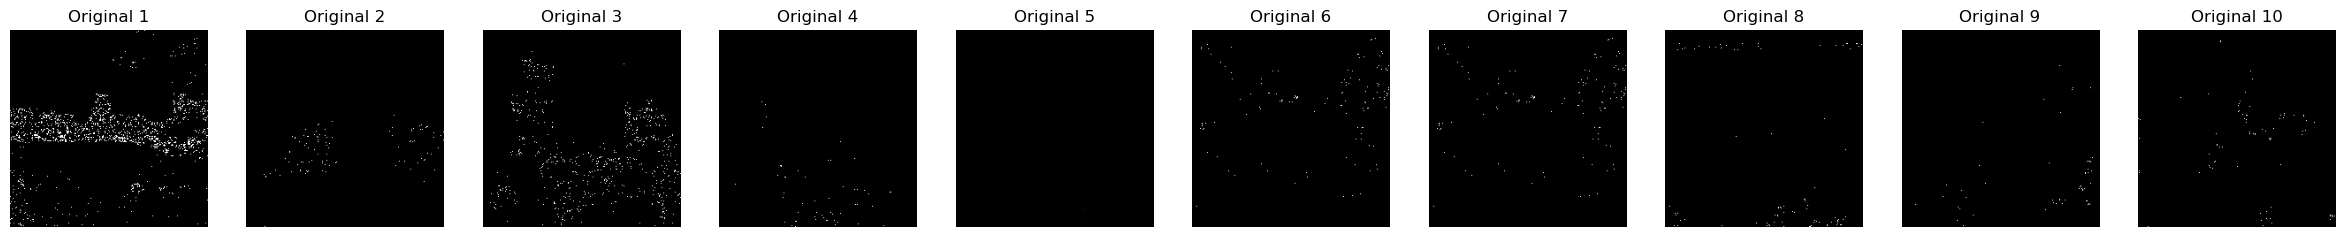

Displaying 10 ELA images converted from tampered images:


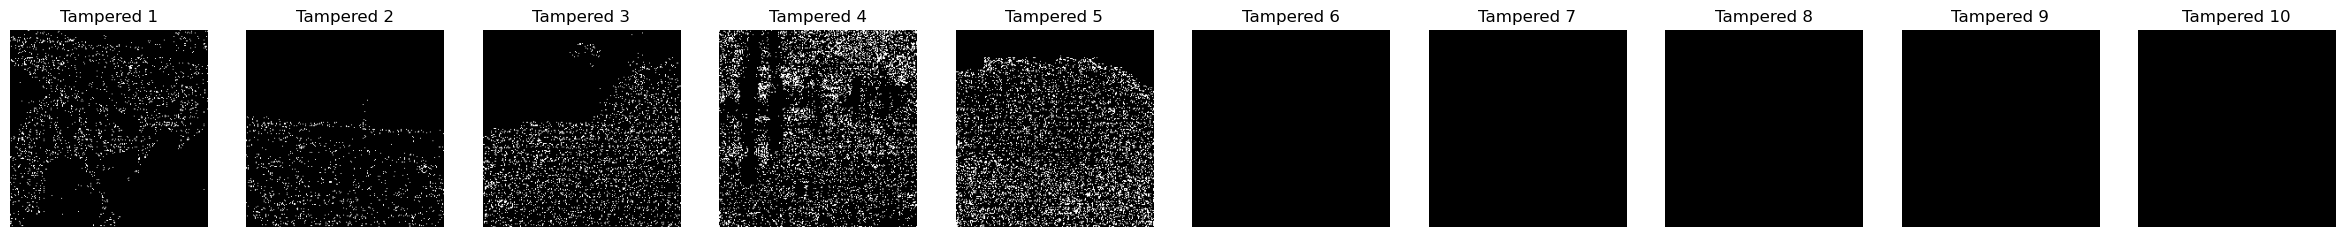

In [3]:
# Displaying ELA Images
def display_ela_images(ela_images, titles):
    fig, axes = plt.subplots(1, len(ela_images), figsize=(30, 30))
    for i, ax in enumerate(axes):
        ax.imshow(ela_images[i], cmap='gray')
        ax.axis('off')
        ax.set_title(titles[i])

# Display 10 ELA images converted from the original images
print("Displaying 10 ELA images converted from original images:")
ela_original_images = [ELA(dataset_path + path_original + i) for i in total_original[:10]]
titles_original = [f"Original {i+1}" for i in range(10)]
display_ela_images(ela_original_images, titles_original)
plt.show()

# Display 10 ELA images converted from the tampered images
print("Displaying 10 ELA images converted from tampered images:")
ela_tampered_images = [ELA(dataset_path + path_tampered + i) for i in total_tampered[:10]]
titles_tampered = [f"Tampered {i+1}" for i in range(10)]
display_ela_images(ela_tampered_images, titles_tampered)
plt.show()

In [4]:
import numpy as np
X=[]
Y=[]
j=0
for file in tqdm(os.listdir(ela_real)):
    img=Image.open(ela_real+file)
    img=np.array(img)
    X.append(img)
    Y.append(0)
    j+=1

j=0
for file in tqdm(os.listdir(ela_fake)):
    img=Image.open(ela_fake+file)
    img=np.array(img)
    X.append(img)
    Y.append(1)
    j+=1


100%|█████████████████████████████████████████████████████████████████████████████| 6500/6500 [00:17<00:00, 375.76it/s]


### This code resizes each image to a size of (224, 224) before converting them into NumPy arrays. 
### After resizing, all images will have the same dimensions

In [5]:
# Function to resize images to a specified size
def resize_image(img_path, target_size=(224, 224)):
    img = Image.open(img_path)
    img = img.resize(target_size)
    return img

X = []
Y = []

# Process original images
for file in tqdm(os.listdir(ela_real)):
    img = resize_image(os.path.join(ela_real, file))
    img_array = np.array(img)
    X.append(img_array)
    Y.append(0)

# Process fake images
for file in tqdm(os.listdir(ela_fake)):
    img = resize_image(os.path.join(ela_fake, file))
    img_array = np.array(img)
    X.append(img_array)
    Y.append(1)

X = np.array(X)
Y = np.array(Y)

print("Shape of X:", X.shape)

100%|█████████████████████████████████████████████████████████████████████████████| 6500/6500 [00:22<00:00, 287.52it/s]


Shape of X: (13000, 224, 224, 3)


In [6]:
X.shape

(13000, 224, 224, 3)

In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Split the data into train and dev sets
x_train, x_dev, y_train, y_dev = train_test_split(X, Y, test_size=0.2, random_state=1, shuffle=True)

# Convert the labels to categorical
y_train = to_categorical(y_train, num_classes=2)
y_dev = to_categorical(y_dev, num_classes=2)


In [8]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.regularizers import l2

# Create the model based on DenseNet121
base_model = DenseNet121(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Unfreeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = Conv2D(1024, (3,3), padding='same', activation='relu')(x)
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
x = Dropout(0.8)(x)
x = Dense(16, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
x = Dense(2, activation='softmax')(x)

model = Model(base_model.input, x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [9]:
epochs = 3
batch_size = 64

In [10]:
import keras
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1,restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 10, verbose = 1)

In [11]:
hist = model.fit(x_train,y_train,
                 epochs = epochs, batch_size = batch_size,
                validation_data = (x_dev,y_dev),
                #callbacks = [early_stop,reduce_lr],
                verbose=1,shuffle=True)

Epoch 1/3


163/163 [==============================] - 3868s 23s/step - loss: 3.2361 - accuracy: 0.9173 - val_loss: 433.5864 - val_accuracy: 0.5085
Epoch 2/3
163/163 [==============================] - 2430s 15s/step - loss: 0.7351 - accuracy: 0.9615 - val_loss: 3.3173 - val_accuracy: 0.7023
Epoch 3/3
163/163 [==============================] - 1819s 11s/step - loss: 0.3702 - accuracy: 0.9656 - val_loss: 5.9449 - val_accuracy: 0.5485


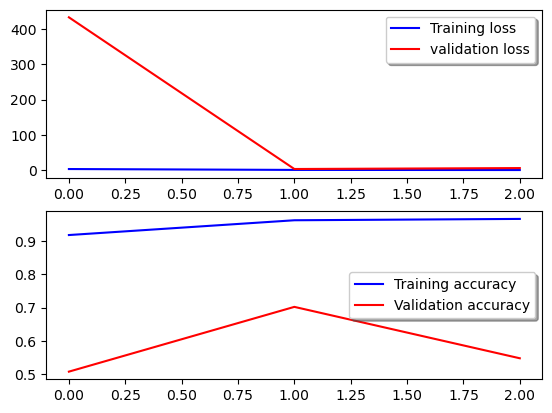

In [12]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

82/82 [==============================] - 141s 2s/step
[[1328    0]
 [1174   98]]
Precision: 1.0
Recall: 0.0770440251572327
F1 Score: 0.14306569343065695
Accuracy: 0.5484615384615384
ROC-AUC Score: 0.8911660794119877


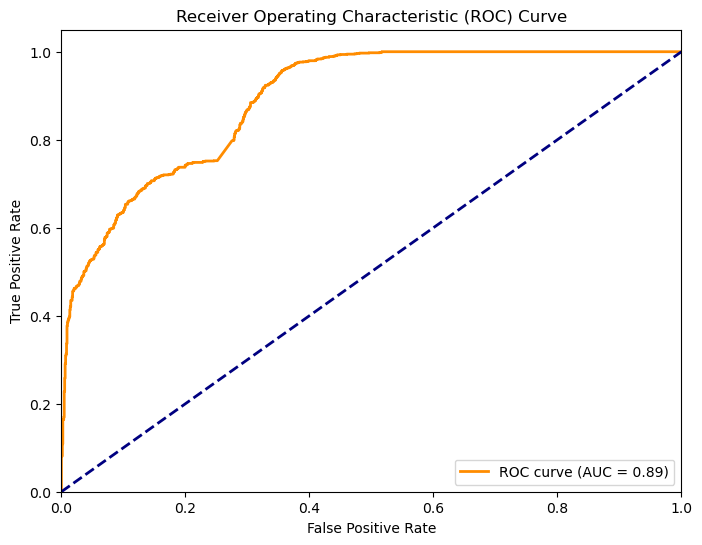

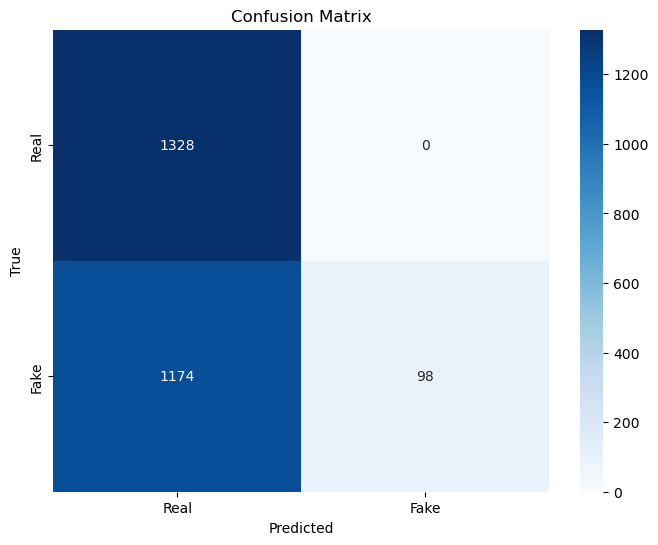

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_curve, roc_auc_score, auc
import seaborn as sns

# Assuming you have the model already trained and 'x_dev' contains the validation data

# Get predictions from the model
y_pred = model.predict(x_dev)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Convert one-hot encoded labels back to categorical labels
y_dev_classes = np.argmax(y_dev, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_dev_classes, y_pred_classes)
print(conf_matrix)
# Define class labels (0: real, 1: fake)
class_labels = ["Real", "Fake"]

# Calculate metrics
precision = precision_score(y_dev_classes, y_pred_classes)
recall = recall_score(y_dev_classes, y_pred_classes)
f1 = f1_score(y_dev_classes, y_pred_classes)
accuracy = accuracy_score(y_dev_classes, y_pred_classes)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)

# Calculate ROC curve and ROC-AUC
fpr, tpr, _ = roc_curve(y_dev_classes, y_pred[:, 1])  # Assuming 1 corresponds to "fake" class
roc_auc = auc(fpr, tpr)

print("ROC-AUC Score:", roc_auc)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


1/1 [==============================] - 0s 194ms/step


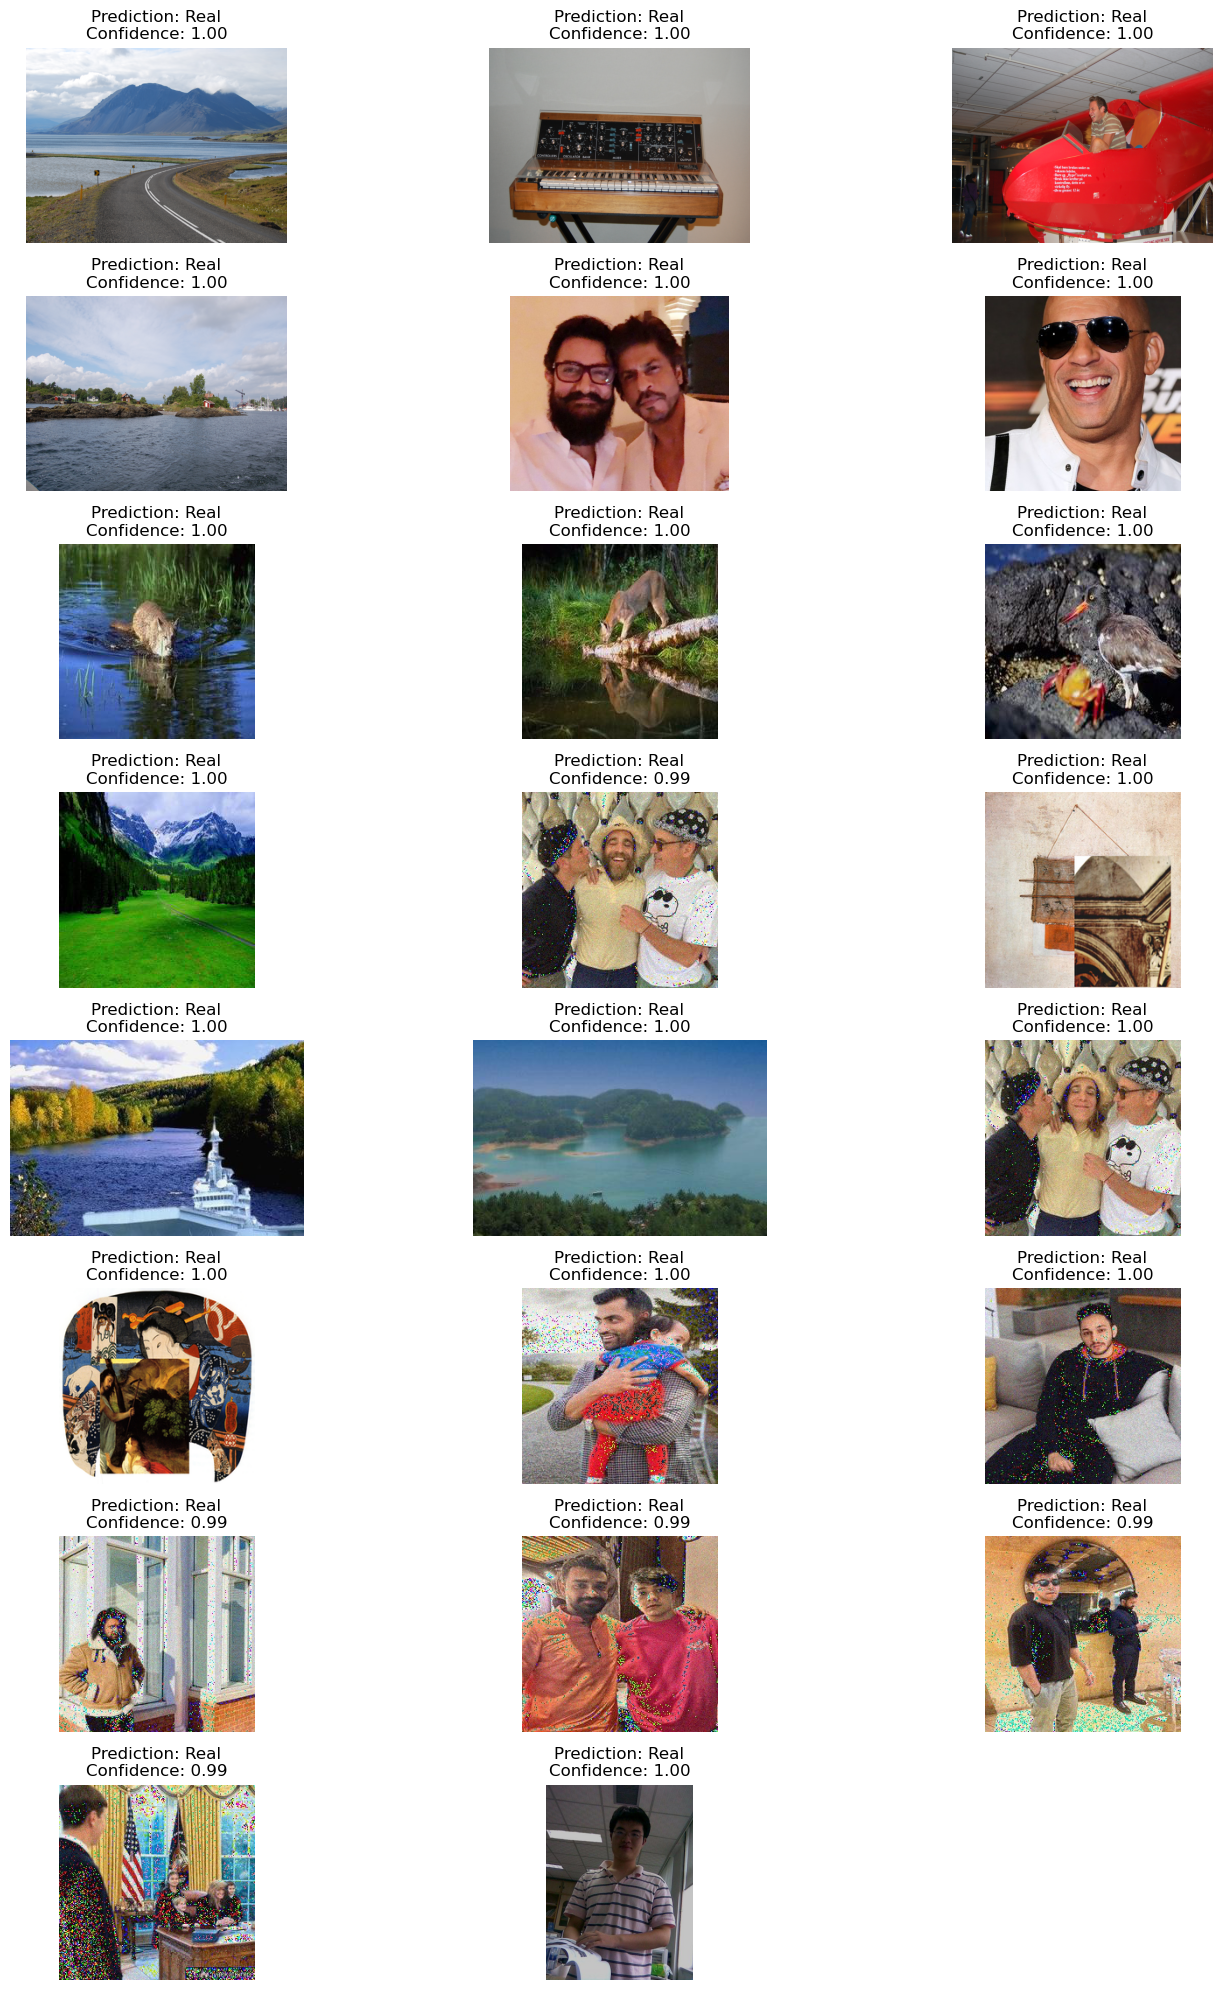

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import load_model


# Function to preprocess an image
def preprocess_image(image_path):
    img = ELA(image_path)
    img = img.resize((224, 224))  # Resize the image to match the input size of your model
    img = np.array(img) # Normalize pixel values to [0, 1]
    return img

# Path to the folder containing random images
image_folder = r"C:\Users\Sejal\Downloads\Input Random Images\Images"



image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]

num_images = len(image_files)
num_cols = 3  # Number of columns in the grid
num_rows = -(-num_images // num_cols)
plt.figure(figsize=(15, 20))

for i, image_file in enumerate(image_files):
    # Preprocess the image
    image_path = os.path.join(image_folder, image_file)
    preprocessed_img = preprocess_image(image_path)

    # Get predictions from the model
    pred_probs = model.predict(np.expand_dims(preprocessed_img, axis=0))[0]
    predicted_class = np.argmax(pred_probs)
    predicted_label = class_labels[predicted_class]
    confidence = pred_probs[predicted_class]

    # Set up the subplot
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(Image.open(image_path))
    plt.title(f"Prediction: {predicted_label}\nConfidence: {confidence:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
total,correct=0,0